In [214]:
import torch
import torch.nn as nn
from torch.optim import SGD

import numpy as np

import matplotlib.pyplot as plt

from scipy.stats import gaussian_kde, entropy

In [215]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(NeuralNet, self).__init__()
        self.hidden = nn.ModuleList()
        self.input_layer = nn.Linear(input_size, hidden_sizes[0])
        for k in range(len(hidden_sizes)-1):
            self.hidden.append(nn.Linear(hidden_sizes[k], hidden_sizes[k+1]))
        self.output_layer = nn.Linear(hidden_sizes[-1], output_size)
        
    def forward(self, x):
        x=self.input_layer(x)
        x=x.relu()
        for layer in self.hidden:
            x=layer(x)
            x=x.relu()
        x=self.output_layer(x)
        return x

    
def ReLU_glorot_init(model):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            nn.init.xavier_normal_(param)

In [216]:
RES=50
EPOCHS=1000
BATCH_SIZE=50
LEARNING_RATE=0.1

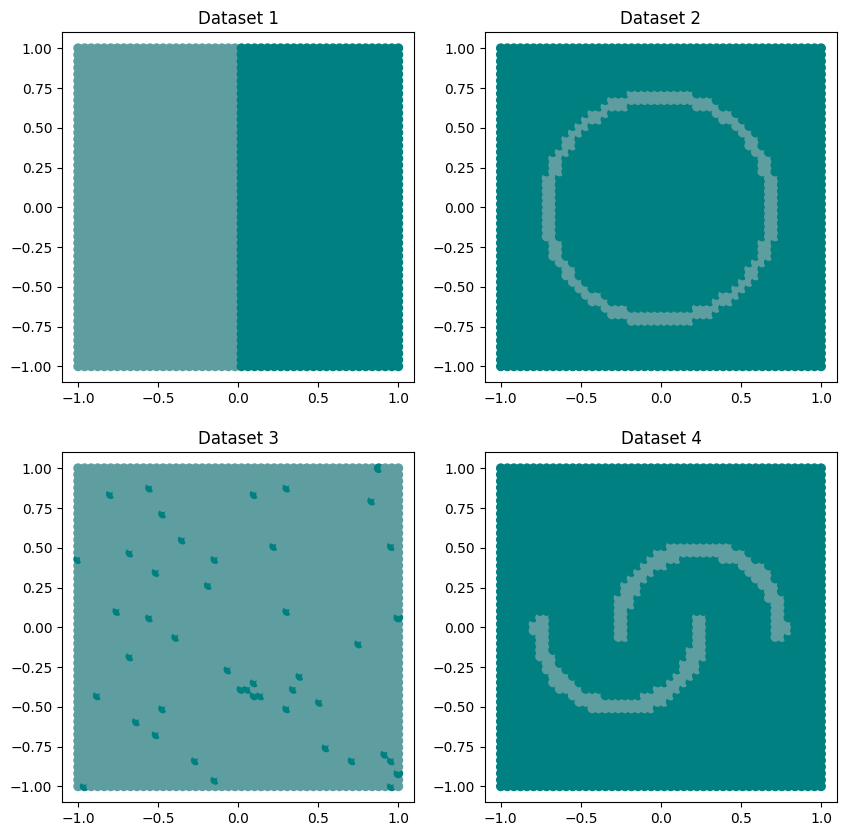

In [217]:
X=[]
for x_1 in np.linspace(-1,1,RES):
    for x_2 in np.linspace(-1,1,RES):
        X.append([x_1,x_2])
X=np.array(X)

classifier1=lambda x: 1 if x[0]<0 else 0
classifier2=lambda x: 1 if abs(x[0]**2+x[1]**2-0.5)<0.05 else 0
classifier3=lambda x: 1 if np.random.random()<0.98 else 0
classifier4=lambda x: 1 if (abs((x[0]+0.25)**2+x[1]**2-0.25)<0.05 and x[1]<0.1) or (abs((x[0]-0.25)**2+x[1]**2-0.25)<0.05 and x[1]>-0.1) else 0

classifiers=[classifier1,classifier2,classifier3,classifier4]

Y1=torch.from_numpy(np.array([classifier1(x) for x in X])).float()
Y2=torch.from_numpy(np.array([classifier2(x) for x in X])).float()
Y3=torch.from_numpy(np.array([classifier3(x) for x in X])).float()
Y4=torch.from_numpy(np.array([classifier4(x) for x in X])).float()
Ys=[Y1,Y2,Y3,Y4]

X=torch.from_numpy(X).float()

fig,axs=plt.subplots(2,2,figsize=(10,10))
for i,row in enumerate(axs):
    for j,ax in enumerate(row):
        colors=np.full(len(Ys[i*2+j]), 'cadetblue')
        colors[Ys[i*2+j]==0]='teal'
        ax.scatter(X[:,0],X[:,1],c=colors)
        ax.set_title('Dataset {}'.format(i*2+j+1))

In [218]:
def next_batch(inputs, targets, batch_size):
    for i in range(0, inputs.shape[0], batch_size):
        yield (inputs[i:i + batch_size], targets[i:i + batch_size])

In [219]:
def analyse_KL(Y,classifier):
    model = NeuralNet(2,[256,256],2)
    ReLU_glorot_init(model)

    opt = SGD(model.parameters(), lr=LEARNING_RATE)
    lossFunc = nn.CrossEntropyLoss()

    def training():
        trainLoss = 0
        samples = 0
        model.train()
        for batchX, batchY in next_batch(X, Y, BATCH_SIZE):
            predictions = model(batchX)
            loss = lossFunc(predictions, batchY.long())
            opt.zero_grad()
            loss.backward()
            opt.step()
            samples += len(batchY)
            trainLoss += loss.item()*len(batchY)
        return trainLoss/samples

    def accuracy(dataset_X,dataset_Y):
        with torch.no_grad():
            correct=0
            samples=0
            for x,y in next_batch(dataset_X,dataset_Y,1):
                prediction=torch.argmax(model(x))
                if prediction==y:
                    correct+=1
                samples+=1
            return correct/samples
    for epoch in range(EPOCHS):
        loss=training()
        if (epoch+1)%50==0:
            print('Epoch {}: Loss {:.3f}'.format(epoch+1,loss))
            if loss<0.01:
                break
    acc=accuracy(X,Y)
    print('Accuracy {:.3f}'.format(acc))
    def perturb_inputs(inputs,sigma):
        inputs+=np.random.normal(0,sigma,inputs.shape)
        return inputs
    trained_outputs=model(X).detach().numpy()
    trained_density=gaussian_kde(trained_outputs.T)(X.T)
    sigmas=np.linspace(0,1,50)
    KLs=[]
    KLs_normalized=[]
    accuracies=[]
    for sigma in sigmas:
        perturbed_X=perturb_inputs(np.array(X),sigma)
        perturbed_Y=np.array([classifier(x) for x in perturbed_X])
        perturbed_X=torch.from_numpy(perturbed_X).float()
        perturbed_Y=torch.from_numpy(perturbed_Y).float()
        accuracies.append(accuracy(perturbed_X,perturbed_Y))
        perturbed_outputs=model(perturbed_X).detach().numpy()
        perturbed_density=gaussian_kde(perturbed_outputs.T)(X.T)
        KL=entropy(trained_density,perturbed_density)
        KLs.append(KL)
        if sigma!=0:
            KLs_normalized.append([KL/sigma])
    return KLs, KLs_normalized,accuracies

In [220]:
dataset_kls=[]
dataset_normalized_kls=[]
dataset_accuracies=[]
for classifier,labels in zip(classifiers,Ys):
    kls,norm_kls,acc=analyse_KL(labels,classifier)
    dataset_kls.append(kls)
    dataset_normalized_kls.append(norm_kls)
    dataset_accuracies.append(acc)

Epoch 50: Loss 0.035
Epoch 100: Loss 0.024
Epoch 150: Loss 0.114
Epoch 200: Loss 0.001
Accuracy 1.000
Epoch 50: Loss 0.262
Epoch 100: Loss 0.199
Epoch 150: Loss 0.112
Epoch 200: Loss 0.092
Epoch 250: Loss 0.089
Epoch 300: Loss 0.066
Epoch 350: Loss 0.086
Epoch 400: Loss 0.060
Epoch 450: Loss 0.060
Epoch 500: Loss 0.048
Epoch 550: Loss 0.059
Epoch 600: Loss 0.071
Epoch 650: Loss 0.066
Epoch 700: Loss 0.044
Epoch 750: Loss 0.043
Epoch 800: Loss 0.037
Epoch 850: Loss 0.040
Epoch 900: Loss 0.033
Epoch 950: Loss 0.027
Epoch 1000: Loss 0.027
Accuracy 0.994
Epoch 50: Loss 0.089
Epoch 100: Loss 0.089
Epoch 150: Loss 0.089
Epoch 200: Loss 0.088
Epoch 250: Loss 0.088
Epoch 300: Loss 0.088
Epoch 350: Loss 0.088
Epoch 400: Loss 0.087
Epoch 450: Loss 0.087
Epoch 500: Loss 0.087
Epoch 550: Loss 0.086
Epoch 600: Loss 0.086
Epoch 650: Loss 0.086
Epoch 700: Loss 0.085
Epoch 750: Loss 0.085
Epoch 800: Loss 0.085
Epoch 850: Loss 0.085
Epoch 900: Loss 0.084
Epoch 950: Loss 0.084
Epoch 1000: Loss 0.084
Acc

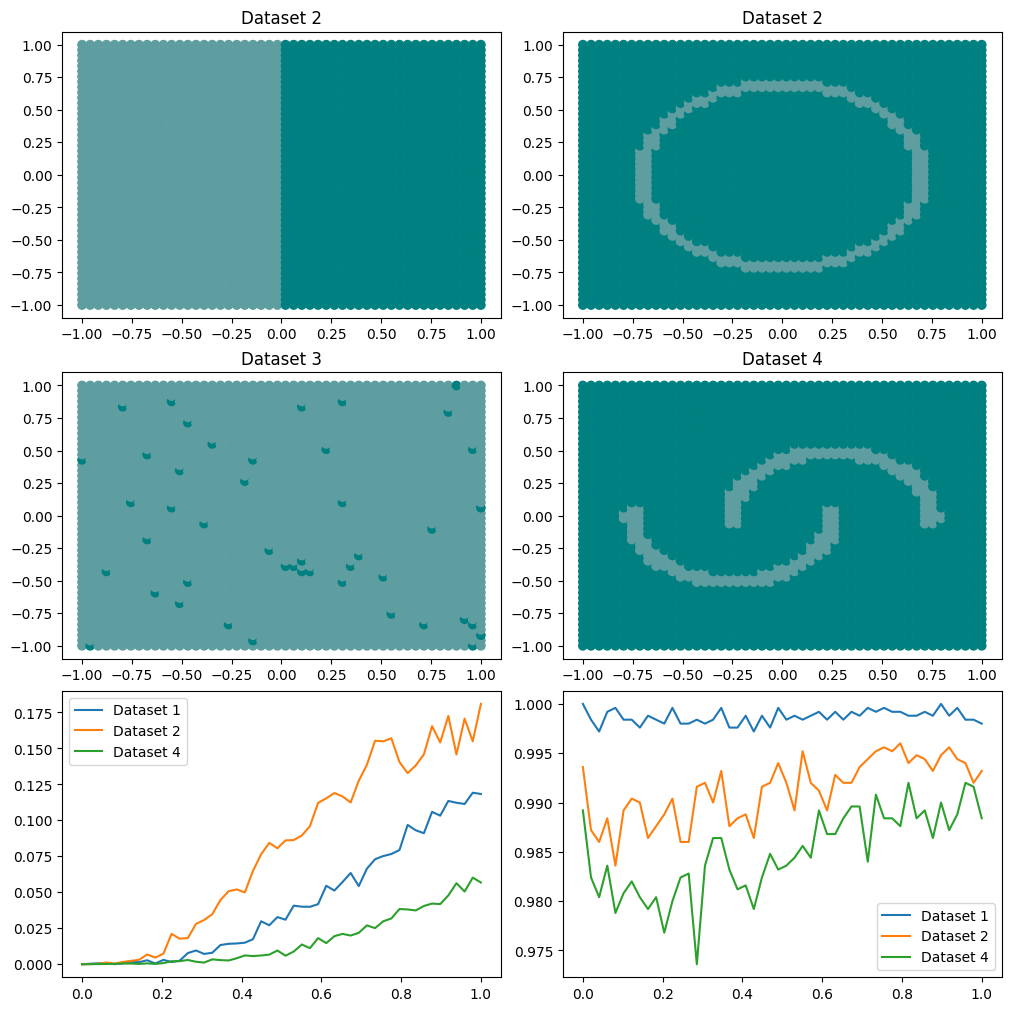

In [229]:
fig = plt.figure(figsize=(10,10),constrained_layout=True)
axs = fig.subplot_mosaic([['dataset1','dataset2'],['dataset3','dataset4'],['KL','accuracy']])


colors1=np.full(len(Y1), 'cadetblue')
colors1[Y1==0]='teal'
axs['dataset1'].scatter(X[:,0],X[:,1],c=colors1)
axs['dataset1'].set_title('Dataset 2')

colors2=np.full(len(Y2), 'cadetblue')
colors2[Y2==0]='teal'
axs['dataset2'].scatter(X[:,0],X[:,1],c=colors2)
axs['dataset2'].set_title('Dataset 2')

colors3=np.full(len(Y3), 'cadetblue')
colors3[Y3==0]='teal'
axs['dataset3'].scatter(X[:,0],X[:,1],c=colors3)
axs['dataset3'].set_title('Dataset 3')

colors4=np.full(len(Y4), 'cadetblue')
colors4[Y4==0]='teal'
axs['dataset4'].scatter(X[:,0],X[:,1],c=colors4)
axs['dataset4'].set_title('Dataset 4')

for k,kl in enumerate(dataset_kls):
    if k==2:
        continue
    axs['KL'].plot(np.linspace(0,1,50),kl,label='Dataset {}'.format(k+1))
axs['KL'].legend()

#for k,norm_kl in enumerate(dataset_normalized_kls):
#    if k==2:
#        continue
#    axs['normKL'].plot(np.linspace(0,1,50)[1:],norm_kl,label='Dataset {}'.format(k+1))
#axs['normKL'].legend()

for k,a in enumerate(dataset_accuracies):
    if k==2:
        continue
    axs['accuracy'].plot(np.linspace(0,1,50),a,label='Dataset {}'.format(k+1))
axs['accuracy'].legend()